### NAME: SAKSHAM LAKHERA
### PERSON NO: 50611360
### DIC PROJECT PHASE 2: HYPOTHESIS CREATION

In [20]:
import pandas as pd
import os
from typing import List, Optional, Dict
import gc
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings("ignore")

In [21]:
# !pip3 install pandas
# !pip3 install pyarrow


### Data Fetch

In [22]:
def fetch_nsduh_data(year: int) -> Optional[pd.DataFrame]:
    """
    Fetches NSDUH data for a specified year from a remote source.

    Args:
        year (int): The year for which to fetch data.

    Returns:
        Optional[pd.DataFrame]: A pandas DataFrame with the data, or None if fetching failed.
    """
    url_placeholder = "https://www.datafiles.samhsa.gov/sites/default/files/field-uploads-protected/studies/NSDUH-{year}/NSDUH-{year}-datasets/NSDUH-{year}-DS0001/NSDUH-{year}-DS0001-bundles-with-study-info/NSDUH-{year}-DS0001-bndl-data-tsv.zip"
    
    try:
        url = url_placeholder.format(year=year)
        df = pd.read_csv(url, compression='zip', sep='\t', low_memory=False)
        return df
    except Exception as e:
        print(f"An error occurred for year {year}: {e}")
        return None

In [23]:
def check_parquet_exists(years: List[int], output_dir: str) -> Dict[int, bool]:
    """
    Checks if Parquet files for the specified years already exist in the output directory.

    Args:
        years (List[int]): A list of years to check.
        output_dir (str): The directory where Parquet files are saved.

    Returns:
        Dict[int, bool]: A dictionary with years as keys and boolean values indicating 
                         whether the Parquet file for that year exists.
    """
    existence_check = {}
    
    for year in years:
        year_path = os.path.join(output_dir, f'year={year}')
        existence_check[year] = os.path.exists(year_path)
    
    return existence_check

In [24]:
def write_parquet(df: pd.DataFrame, year: int, output_dir: str, overwrite: bool = False) -> None:
    """
    Writes a DataFrame to Parquet format, partitioned by year.

    Args:
        df (pd.DataFrame): The DataFrame to write.
        year (int): The year of the data.
        output_dir (str): The directory where Parquet files will be saved.
        overwrite (bool): If True, overwrite existing files. If False, skip existing files.
    """
    try:
        year_dir = os.path.join(output_dir, f'year={year}')
        if overwrite and os.path.exists(year_dir):
            shutil.rmtree(year_dir)  # Remove existing directory to start fresh

        df['year'] = year  # Add the year column for partitioning
        # Write data to Parquet format with partitioning
        df.to_parquet(output_dir, partition_cols=['year'], index=False)
        
        print(f"Data for year {year} successfully saved to Parquet format in {output_dir}")
    except Exception as e:
        print(f"Error saving data to Parquet for year {year}: {e}")

In [25]:
def data_fetch(years_to_fetch: List[int], output_dir: str, overwrite: bool = False) -> None:
    """
    Fetches NSDUH data for specified years and saves it to Parquet format, one year at a time.

    Args:
        years_to_fetch (List[int]): A list of years for which to fetch data.
        output_dir (str): The directory where Parquet files will be saved.
        overwrite (bool): If True, overwrite existing files. If False, skip existing files.
    """
    try:
        for year in years_to_fetch:
            if not overwrite and os.path.exists(os.path.join(output_dir, f'year={year}')):
                print(f"Data for year {year} already exists. Skipping.")
                continue

            df = fetch_nsduh_data(year)
            if df is not None:
                print(f"Successfully fetched data for year: {year}")
                write_parquet(df, year, output_dir, overwrite)
                del df  # Remove the DataFrame from memory
                gc.collect()  # Force garbage collection

        print("All requested years processed.")
    except Exception as e:
        print(f"An unexpected error occurred in the data_fetch function: {e}")

In [26]:
def read_parquet(input_dir: str, years: Optional[List[int]] = None) -> Dict[int, pd.DataFrame]:
    """
    Reads Parquet files for specified years from the input directory.

    Args:
        input_dir (str): The directory where Parquet files are stored.
        years (Optional[List[int]]): A list of years to read. If None, read all available years.

    Returns:
        Dict[int, pd.DataFrame]: A dictionary with years as keys and pandas DataFrames as values.
    """
    data_frames = {}
    available_years = [int(d.split('=')[1]) for d in os.listdir(input_dir) if d.startswith('year=')]
    years_to_read = years if years is not None else available_years

    for year in years_to_read:
        year_path = os.path.join(input_dir, f'year={year}')
        if os.path.exists(year_path):
            df = pd.read_parquet(year_path)
            data_frames[year] = df
        else:
            print(f"Warning: No data found for year {year}")

    return data_frames

In [27]:
if __name__ == "__main__":
    years = [2015, 2016, 2017, 2018, 2019] 
    output_directory = "./data/DS/NSDUH"
    
    # Fetch and save data
    data_fetch(years, output_directory, overwrite=False)

    # Initialize an empty DataFrame to hold all data
    df = pd.DataFrame()

    # Read saved data and concatenate into df
    for year in years:
        df_year = read_parquet(output_directory, [year])
        if year in df_year:
            # Concatenate the current year's DataFrame to df
            df = pd.concat([df, df_year[year]], ignore_index=True)


Data for year 2015 already exists. Skipping.
Data for year 2016 already exists. Skipping.
Data for year 2017 already exists. Skipping.
Data for year 2018 already exists. Skipping.
Data for year 2019 already exists. Skipping.
All requested years processed.


### DATA CLEANING

What we have done
1. Handling Missing Data: Change missing values to 101.
2. Correcting Data Types: if in numeric column we found string we assigned it as 101
3. NAN is assigned as 101
4. Removing Unnecessary columns that don't contribute to analysis.

In [28]:
data_frame = df.copy()
# All these column have numneic value, so if any string or NAN or empty value is given 101 value.
columns_required = [
    'SUICTHNK', 'SNRLGIMP', 'ILLALCFLG', 'PNRNMFLAG', 'TRQNMFLAG',
    'STMNMFLAG', 'SEDNMFLAG', 'TQSDNMFLAG', 'PSYCHFLAG', 'OPINMYR',
    'HVYDRKMON', 'CIG30USE', 'ILLALCFLG', 'IRINSUR4', 'IRWRKSTAT',
    'PARCHKHW', 'PARHLPHW', 'PRCHORE2', 'PRLMTTV2', 'PARLMTSN',
    'PRGDJOB2', 'PRPROUD2', 'ARGUPAR', 'PRTALK3'
]

def clean_data(df, columns):
    for col in columns:
        # Convert column to numeric, forcing errors to NaN (which will catch strings and invalid data)
        df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Replace NaN values with 101
        df[col].fillna(101, inplace=True)
    
    return df

data_frame_cleaned = clean_data(data_frame, columns_required)
# Removing Unnecessary Data that don't contribute to analysis.
data_frame_cleaned = data_frame[columns_required]
# Now all columns will be cleaned, with NaN or invalid data replaced by 101, and all columns as integers.


### Hypothesis 1: Does Cigarette Smoking a cause for mental health?

Question we will be answering:
1. Does smoking cigarette have any effect on mental health?
2. if smoking Cigarette doesn't cause the mental health, then is it the environmental factor.
3. Which section of society is most susceptible to depression because of Smoking

Hypothesis Space: 

We will take only those people who smoke cigarette but no alcohol or drugs. 
We can divide them into 2 parts:
1. People who smoke cigarette and have tried drugs but never misused as it's believed that if someone tried cigarette then they might have tried alcohol or any other intoxicant.
2. People who smokes but never tried alcohol or drugs at all.

We need to compare these 2 categories and see the effect of cigarette on suicidal thoughts/depression.
In case cigarette is not the factor, then mostly society is and so we need to find how people think about smoking cigarette in different section of society.

Note: We consider "smokers" as People who smoke at least 10 days in a month.

Note: It's proven fact that smoking causes health issue and withdrawal symptoms after leaving smoking causes anxiety and depression. In this hypothesis we are considering people who are still smoking and smoking it part of their normal life.

In [29]:
# This filter have people who can be smoker but never in life misused alchol or drugs, 
# and maybe have tried or taken for some use
# People have tried drugs like for medical purpose but never have misused. eg: Even heroine is sometimes used for painrelief

### EXTRA CLEANING
df_smoker_no_misuse = data_frame[
    (data_frame['SUICTHNK'] >= 1) & (data_frame['SUICTHNK'] <= 2) &
    (
        ((data_frame['CIG30USE'] >= 10) & (data_frame['CIG30USE'] <= 30)) |
        (data_frame['CIG30USE'] == 91)
    ) &
    (data_frame['PNRNMFLAG'] == 0) &
    (data_frame['TRQNMFLAG'] == 0) &
    (data_frame['STMNMFLAG'] == 0) &
    (data_frame['SEDNMFLAG'] == 0) &
    (data_frame['TQSDNMFLAG'] == 0) &
    (data_frame['PSYCHFLAG'] == 0) &
    (data_frame['OPINMYR'] == 0) & 
    (data_frame['HVYDRKMON'] == 0)  # No heavydeinking/ misuse
]
# Above is extra filter with cleaning, we make sure that all paramaters we are looking at is in specif range

# This filter have people who can be smmoker but never have even tried alchol or dugs in life
df_smoker_neverdrugs = data_frame[
    (data_frame['SUICTHNK'] >= 1) & (data_frame['SUICTHNK'] <= 2) &
    (
        ((data_frame['CIG30USE'] >= 10) & (data_frame['CIG30USE'] <= 30)) | # smoke 10-30 days a month
        (data_frame['CIG30USE'] == 91) # no Ciggratte
    ) &
    (data_frame['ILLALCFLG'] == 0) # no alchol and drug ever in life
] 
# Above is extra filter with cleaning, we make sure that all paramaters we are looking at is in specif range

df_smoker_no_misuse['CIG30USE'] = df_smoker_no_misuse['CIG30USE'].apply(lambda x: 1 if 1 <= x <= 30 else 0)
df_smoker_neverdrugs['CIG30USE'] = df_smoker_neverdrugs['CIG30USE'].apply(lambda x: 1 if 1 <= x <= 30 else 0)
df_smoker_no_misuse['CIG30USE'] = df_smoker_no_misuse['CIG30USE'].replace(91, 0)
df_smoker_neverdrugs['CIG30USE'] = df_smoker_neverdrugs['CIG30USE'].replace(91, 0)

df_result_smoker_no_misuse = df_smoker_no_misuse.groupby(['INCOME', 'CIG30USE']).agg(
    sucide_mean=('SUICTHNK', 'mean')
).reset_index()
df_result_smoker_neverdrugs = df_smoker_neverdrugs.groupby(['INCOME', 'CIG30USE']).agg(
    sucide_mean=('SUICTHNK', 'mean')
).reset_index()



In [30]:
df_ciggratte_view = data_frame[
    (data_frame['YEPPKCIG'] >= 1) & (data_frame['YEPPKCIG'] <= 3) &
    (data_frame['INCOME'] >= 1) & (data_frame['INCOME'] <= 4)
] 
result_df_ciggratte_view = df_ciggratte_view.groupby(['INCOME']).agg(
    ciggratte_view=('YEPPKCIG', 'mean')
).reset_index()
# Above is extra filter with cleaning, we make sure that all paramaters we are looking at is in specif range

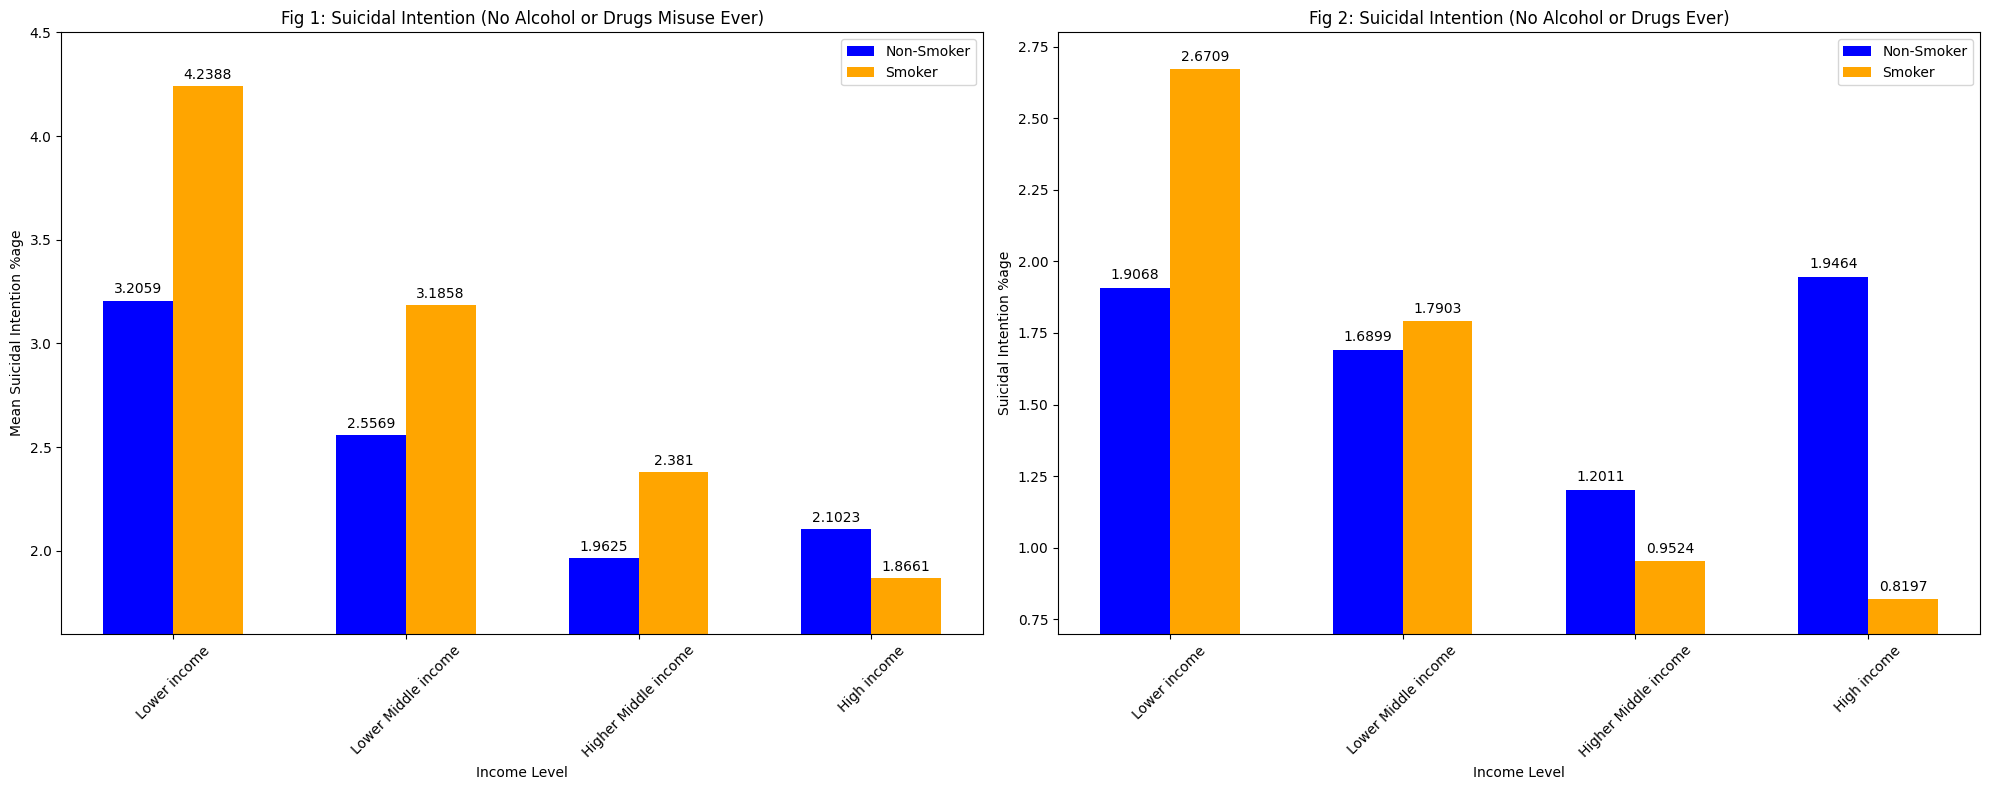

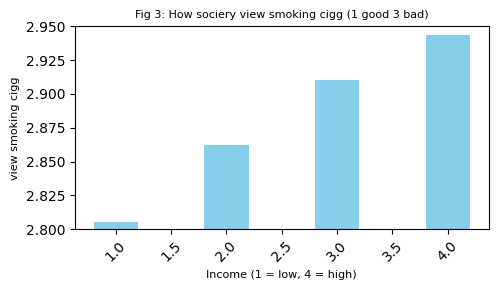

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Define the mapping for CIG30USE
cig_labels = {0: "Non-Smoker", 1: "Smoker"}
income_labels = {1: "Lower income", 2: "Lower Middle income", 3: "Higher Middle income", 4: "High income"}

result1_pivot = df_result_smoker_no_misuse.pivot(index='INCOME', columns='CIG30USE', values='sucide_mean').fillna(0)

bar_width = 0.3
indices1 = np.arange(len(result1_pivot))

bars1 = ax[0].bar(indices1 - bar_width/2, 100 - result1_pivot[0]*50, bar_width, label='Non-Smoker', color='blue')
bars2 = ax[0].bar(indices1 + bar_width/2, 100 - result1_pivot[1]*50, bar_width, label='Smoker', color='orange')

ax[0].set_title('Fig 1: Suicidal Intention (No Alcohol or Drugs Misuse Ever)')
ax[0].set_xlabel('Income Level')
ax[0].set_ylabel('Mean Suicidal Intention %age')
ax[0].set_xticks(indices1)
ax[0].set_xticklabels([income_labels[i] for i in result1_pivot.index], rotation=45)
ax[0].legend()
ax[0].set_ylim(1.6, 4.5)
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 4), ha='center', va='bottom')

result2_pivot = df_result_smoker_neverdrugs.pivot(index='INCOME', columns='CIG30USE', values='sucide_mean').fillna(0)
indices2 = np.arange(len(result2_pivot))

bars3 = ax[1].bar(indices2 - bar_width/2, 100 - result2_pivot[0]*50, bar_width, label='Non-Smoker', color='blue')
bars4 = ax[1].bar(indices2 + bar_width/2, 100 - result2_pivot[1]*50, bar_width, label='Smoker', color='orange')

ax[1].set_title('Fig 2: Suicidal Intention (No Alcohol or Drugs Ever)')
ax[1].set_xlabel('Income Level')
ax[1].set_ylabel('Suicidal Intention %age')
ax[1].set_xticks(indices2)
ax[1].set_xticklabels([income_labels[i] for i in result2_pivot.index], rotation=45)
ax[1].legend()
ax[1].set_ylim(0.7, 2.8)
for bar in bars3 + bars4:
    yval = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 4), ha='center', va='bottom')

plt.tight_layout()
plt.show()
labels = result_df_ciggratte_view['INCOME']
sizes = result_df_ciggratte_view['ciggratte_view']
labels = result_df_ciggratte_view['INCOME']
sizes = result_df_ciggratte_view['ciggratte_view']
plt.figure(figsize=(5, 3))
plt.bar(labels, sizes, color='skyblue',width=0.4)

plt.title('Fig 3: How sociery view smoking cigg (1 good 3 bad)', fontsize=8)
plt.xlabel('Income (1 = low, 4 = high)', fontsize=8)
plt.ylabel('view smoking cigg', fontsize=8)

plt.xticks(rotation=45)
plt.ylim(2.8, 2.95)
plt.tight_layout()
plt.show()


#### OBSERVATION
High earning > $75000

low earning < $20000

From fig 1 and fig 2, we can see that Suicidal intention is more for nonsmokers with higher income. Whereas with decrease with income smokers tends to become more depressed. 

We can say that smoking is one of the factors for depression in low earning people but for high earning people smoking becomes a tool to curb depression. 

Fig 3 shows how different income society thinks of smoking cigarette, we can see that people with lower income doesn't see it as bad of a habit as compared to high income society, but still the lower income smokers have the high sucidal thought percentage. 

Lower-income smokers may have higher depression rates due to stress from financial and job issues and limited access to healthcare (as we can see from the fig1 and fig2 lower income people are more stressed than high income people). Smoking is often used as a coping mechanism for stress, which can worsen mental health over time.

#### CONCLUSION
1. Nicotine/Smoking is not the main cause of depression, it's the societal view in which a person is born and lives in.
2. A low earning person should avoid cigarette smoking as much possible.

In conclusion, it's the societal/financial/personal cause can be a cause for smoker to go into depression. 
hence, Cigarette smoking is not a direct factor of depression but an indirect one.

Note: It's proven fact that smoking causes health issue and withdrawl symptoms after leaving smoking causes anxiety and depression. In this hypothesis we are considering people who are still smoking and smoking it part of their normal life.

####

### HYPOTHESIS 2: Does Being religious lowers rate of suicidal thoughts?
Questions we will be answering:
1. Is RELIGIOUS Belief one of the factors of Mental health?
2. if Religious is one of the factors, then will believing in GOD help you fight depression?

Hypothesis space: 
Some people believe that being religious can reduce stress and negative emotions, while others argue that faith can increase stress. This is because people may feel pressured to adhere to strict religious practices that are difficult to follow.

Note: In our hypothesis we will take only those people who have never done drugs or alcohol in life

   SNRLGIMP  count
0         1   3699
1         2   2121
2         3   7648
3         4  12066


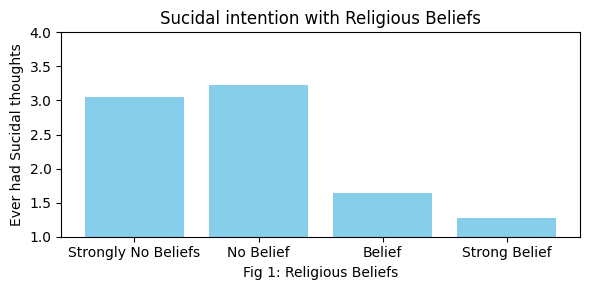

In [32]:
# EXTRA CLEANING
df_religious_belief = data_frame[
    (data_frame['SUICTHNK'] >= 1) & (data_frame['SUICTHNK'] <= 2) & # sucidal thoughts
    (data_frame['SNRLGIMP'] >= 1) & (data_frame['SNRLGIMP'] <= 4) & # relifious belief
    (data_frame['ILLALCFLG'] == 0) # no alchol and drug ever in life
] 
# Above is extra filter with cleaning, we make sure that all paramaters we are looking at is in specif range

df_result_religious_belief = df_religious_belief.groupby(['SNRLGIMP']).agg(
    SUICTHNK_mean=('SUICTHNK', 'mean'),
    count=('SUICTHNK', 'count')
).reset_index()
belief_mapping = {
    1: 'Strongly No Beliefs',
    2: 'No Belief',
    3: 'Belief',
    4: 'Strong Belief'
}
print(df_result_religious_belief[['SNRLGIMP','count']])
# count shows that we have suffieient data to perform analysis

df_result_religious_belief['Belief_Labels'] = df_result_religious_belief['SNRLGIMP'].map(belief_mapping)
plt.figure(figsize=(6, 3))
plt.bar(df_result_religious_belief['Belief_Labels'], 100-(df_result_religious_belief['SUICTHNK_mean'])*50, color='skyblue')
plt.xlabel('Fig 1: Religious Beliefs')
plt.ylabel('Ever had Sucidal thoughts')
plt.title('Sucidal intention with Religious Beliefs')
plt.xticks(rotation=0)
plt.ylim(1, 4)
plt.tight_layout()
plt.show()

##### OBSERVATION
From the fig 1, we can see that people with “strong religious belief” are less susceptible to suicidal thoughts than the people with less to absolutely no religious belief. 
We can see that there is drastic increase in suicidal thought between religious than non-religious people.

Strong No belief: Strongly think their religious belief are not important
No belief: Doesn't think their religious belief are important
Belief: Think their religious belief are important
Strong belief: Strongly think their religious belief are important
People who don’t have religious belief but also doesn't strongly oppose it (no belief people) are the one with most suicidal thought.
Note: People who believe in God can also have feeling that their religious belief are not important in some scenarios. So, this study is also about them.
#### CONCLUSION
1. "Yes", religious belief is an important factor for depression and suicidal thoughts.
2. Having religious belief makes you less susceptible to depression
3. People with strong religious beliefs may be less susceptible to depression because their faith often provides a sense of purpose, community, and hope, which can fight against feelings of despair

Note: This is just data driven insights.



###

### HYPOTHESIS 3: Is having or not having insurance a factor for mental health?

Questions we will be Answering:
1. Does having an insurance makes you less susceptible to depression?
2. How does an insurance play a role in society regarding mental health?

Hypothesis Space: 

We will investigate different category of people who are non-alcoholic and never did drugs and check their depression and compare it with respect to insurance. If insurance is a factor for mental health, then it probably due to fact that having an insurance gives feeling of safety in case of emergency.

In [33]:
def categorize(row):
    if row['column_name'] == 'INCOME':
        if row['weighted_mean_value'] < 2:
            return 'Low income'
        elif 2 <= row['weighted_mean_value'] < 3:
            return 'Middle income'
        else:
            return 'High income'
    elif row['column_name'] == 'IRINSUR4':
        return 'Has Insurance' if row['weighted_mean_value'] < 1.5 else 'Does Not Have Insurance'
    elif row['column_name'] == 'IRWRKSTAT':
        if row['weighted_mean_value'] < 2:
            return 'Working'
        elif 2 <= row['weighted_mean_value'] < 3:
            return 'Not Working/Part-time'
    elif row['column_name'] == 'COUTYP4':
        if row['weighted_mean_value'] < 2:
            return 'Metro'
        elif row['weighted_mean_value'] < 2.5:
            return "Small metro"
        else:
            return "Nonmetro"
    return ''

In [34]:
insurance_depression_high = data_frame[
    (data_frame['SUICTHNK'] >= 1) & (data_frame['SUICTHNK'] <= 2) &
    (data_frame['IRINSUR4'] == 2) & #(data_frame['IRINSUR4'] <= 2) &
    (data_frame['IRWRKSTAT'] == 1) & #(data_frame['IRWRKSTAT'] <= 3) &
    (data_frame['INCOME'] == 4) & #(data_frame['INCOME'] <= 4) &
    (data_frame['ILLALCFLG'] == 1)
] 
result_insurance_depression_high = insurance_depression_high.groupby(['IRINSUR4','IRWRKSTAT','COUTYP4','INCOME']).agg(
    count=('ILLALCFLG', 'count'), #ILLALCFLG
    sucide=('SUICTHNK', 'mean')
).reset_index()
print(result_insurance_depression_high)
#&(result_insurance_depression_high['sucide']>1.93)
result_insurance_depression_high_filtered = result_insurance_depression_high[(result_insurance_depression_high['count'] > 50)].reset_index(drop=True)
#result_insurance_depression_high_filtered = result_insurance_depression_high_filtered.sort_values(by='sucide', ascending=False).reset_index(drop=True)
columns_to_multiply = result_insurance_depression_high_filtered.columns.difference(['count'])  # Select all columns except 'count'
multiplied_df = result_insurance_depression_high_filtered[columns_to_multiply].multiply(result_insurance_depression_high_filtered['count'], axis=0)
sum_multiplied = multiplied_df.sum()
sum_count = result_insurance_depression_high_filtered['count'].sum()
weighted_mean_depression_high_filtered = (sum_multiplied / sum_count).to_frame(name='weighted_mean_value').reset_index()
weighted_mean_depression_high_filtered.columns = ['column_name', 'weighted_mean_value']
weighted_mean_depression_high_filtered['category'] = weighted_mean_depression_high_filtered.apply(categorize, axis=1)

   IRINSUR4  IRWRKSTAT  COUTYP4  INCOME  count    sucide
0         2          1        1       4    671  1.915052
1         2          1        2       4    461  1.930586
2         2          1        3       4    268  1.951493


In [35]:
insurance_depression_low = data_frame[
    (data_frame['SUICTHNK'] >= 1) & (data_frame['SUICTHNK'] <= 2) &
    (data_frame['IRINSUR4'] == 1) & #(data_frame['IRINSUR4'] <= 2) &
    (data_frame['IRWRKSTAT'] == 1) & #(data_frame['IRWRKSTAT'] <= 3) &
    (data_frame['INCOME'] == 4) & #(data_frame['INCOME'] <= 4) &
    (data_frame['ILLALCFLG'] == 1) 
] 
result_insurance_depression_low = insurance_depression_low.groupby(['IRINSUR4','IRWRKSTAT','COUTYP4','INCOME']).agg(
    count=('ILLALCFLG', 'count'), #ILLALCFLG
    sucide=('SUICTHNK', 'mean')
).reset_index()
print(result_insurance_depression_low)
result_insurance_depression_low_filtered = result_insurance_depression_low[(result_insurance_depression_low['count'] > 50)].reset_index(drop=True)
#result_insurance_depression_low_filtered = result_insurance_depression_low_filtered.sort_values(by='sucide', ascending=False).reset_index(drop=True)

columns_to_multiply = result_insurance_depression_low_filtered.columns.difference(['count'])  # Select all columns except 'count'
multiplied_df = result_insurance_depression_low_filtered[columns_to_multiply].multiply(result_insurance_depression_low_filtered['count'], axis=0)
sum_multiplied = multiplied_df.sum()
sum_count = result_insurance_depression_low_filtered['count'].sum()
weighted_mean_depression_low_filtered = (sum_multiplied / sum_count).to_frame(name='weighted_mean_value').reset_index()
weighted_mean_depression_low_filtered.columns = ['column_name', 'weighted_mean_value']
weighted_mean_depression_low_filtered['category'] = weighted_mean_depression_low_filtered.apply(categorize, axis=1)

   IRINSUR4  IRWRKSTAT  COUTYP4  INCOME  count    sucide
0         1          1        1       4  22223  1.965261
1         1          1        2       4  14194  1.963788
2         1          1        3       4   6824  1.968787


  column_name  weighted_mean_value       category
0     COUTYP4             1.643880          Metro
1      INCOME             4.000000    High income
2    IRINSUR4             1.000000  Has Insurance
3   IRWRKSTAT             1.000000        Working
4      sucide             1.965334               
  column_name  weighted_mean_value                 category
0     COUTYP4             1.712143                    Metro
1      INCOME             4.000000              High income
2    IRINSUR4             2.000000  Does Not Have Insurance
3   IRWRKSTAT             1.000000                  Working
4      sucide             1.927143                         
Metro,High income,Has Insurance,Working, Metro,High income,Does Not Have Insurance,Working,
Metro,High income,Has Insurance,Working, 0.9653338266922598
Metro,High income,Does Not Have Insurance,Working, 0.927142857142857


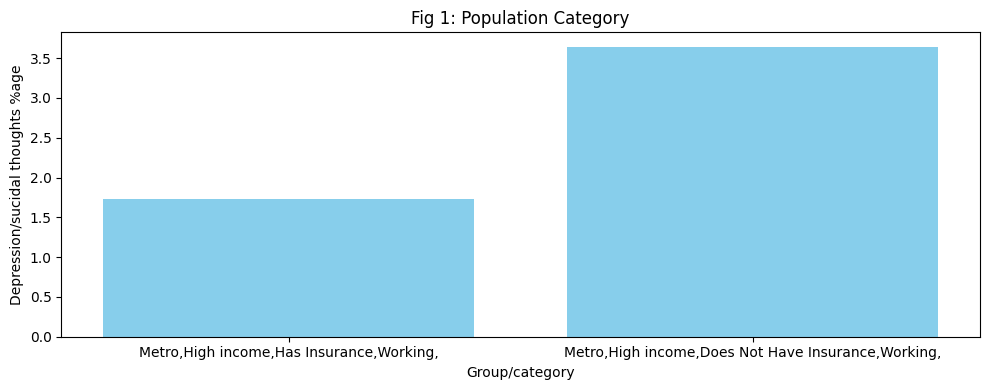

In [36]:
print(weighted_mean_depression_low_filtered)
print(weighted_mean_depression_high_filtered)
x_value_low = ','.join(cat for cat in weighted_mean_depression_low_filtered['category'])
x_value_high= ','.join(cat for cat in weighted_mean_depression_high_filtered['category'])
print(x_value_low,x_value_high)
high_sucide_row = weighted_mean_depression_high_filtered[weighted_mean_depression_high_filtered['column_name'] == 'sucide']
high_sucide_value=(high_sucide_row['weighted_mean_value'].values[0])
low_sucide_row = weighted_mean_depression_low_filtered[weighted_mean_depression_low_filtered['column_name'] == 'sucide']
low_sucide_value = (low_sucide_row['weighted_mean_value'].values[0])
print(x_value_low,low_sucide_value-1)
print(x_value_high,high_sucide_value-1)

x_labels = [x_value_low, x_value_high]
y_values = [100-(low_sucide_value)*50, 100-(high_sucide_value)*50]

plt.figure(figsize=(10, 4))
plt.bar(x_labels, y_values, color='skyblue') 

# Set title and labels
plt.title('Fig 1: Population Category')  
plt.xlabel('Group/category') 
plt.ylabel('Depression/sucidal thoughts %age') 
plt.xticks(rotation=0) 
plt.tight_layout() 
#plt.ylim(86, 96)
plt.show()

#### OBSERVATION
The fig 1 shows suicidal intention among people who lives in metro city, have fulltime job and earns more than $70000 a year but one with insurance and one without.
1. The people without insurance are more depressed in the same class of people as compared to people with insurance.

#### CONCLUSION
1. A high income individual without an insurance is more depressed 
2. We can believe that having insurance gives them a hope of safety, and they are not tensed about their medical coverage in case of emergency.

In conclusion, Insurance is indeed one of the factors that effects mental health. If you have a good income then better to have an insurance.

####

### HYPOTHESIS 4: Which small behavioral factor of parents effects their kids mental health??

Questions we will be answering:
1. Which all small behavioral factors can cause severe mental effects on children. These small behavioral patterns are something that seems useless to parents or us but many effects kids. eg: letting them watch tv, phone etc.
2. Which of these behavioral factors are important factor of mental health? and which are not and can be neglected.
3. We will be taking few of such factors in consideration like help kids in homework, check their homework, make kids to do house chorus, limit their Tv time, limit games during school night, fight with them/scold them, tell them they did a good job, and you are proud of them.

Hypothesis Space:
We will check all combination of behavior and find out the best behavior pattern a parent should follow and compare it with worse behavior and figure out those pattern which have got the most severe effects on child’s mental health.

In [37]:
data_behavourial = data_frame[
    (data_frame['PARCHKHW'] >= 1) & (data_frame['PARCHKHW'] <= 2) &
    (data_frame['PARHLPHW'] >= 1) & (data_frame['PARHLPHW'] <= 2) &
    (data_frame['PRCHORE2'] >= 1) & (data_frame['PRCHORE2'] <= 2) &
    (data_frame['PRLMTTV2'] >= 1) & (data_frame['PRLMTTV2'] <= 2) &
    (data_frame['PARLMTSN'] >= 1) & (data_frame['PARLMTSN'] <= 2) &
    (data_frame['PRGDJOB2'] >= 1) & (data_frame['PRGDJOB2'] <= 2) &
    (data_frame['PRPROUD2'] >= 1) & (data_frame['PRPROUD2'] <= 2) &
    (data_frame['ARGUPAR'] >= 1) & (data_frame['ARGUPAR'] <= 2) &
    (data_frame['PRTALK3'] >= 1) & (data_frame['PRTALK3'] <= 2) 
    
]
# Group by the specified columns
result_data_behavourial = data_behavourial.groupby(
    ['PARCHKHW','PARHLPHW', 'PRCHORE2', 'PRLMTTV2', 'PARLMTSN', 'PRGDJOB2','PRPROUD2','ARGUPAR','PRTALK3']
).agg(
    depression=('YMDELT', 'mean'),
    count=('YMDELT', 'count')
).reset_index()
result_best_behavourial_filtered = result_data_behavourial[(result_data_behavourial['count'] > 100) & (result_data_behavourial['depression'] > 1.75)].reset_index(drop=True)

result_worse_behavourial_filtered = result_data_behavourial[(result_data_behavourial['count'] > 100) & (result_data_behavourial['depression'] < 1.5)].reset_index(drop=True)

result_best_behavourial_filtered = result_best_behavourial_filtered.sort_values(by='depression', ascending=False).reset_index(drop=True)

best_behavourial_count_1 = (result_best_behavourial_filtered == 1).sum()
best_behavourial_count_2 = (result_best_behavourial_filtered == 2).sum()

worse_behavourial_count_1 = (result_worse_behavourial_filtered == 1).sum()
worse_behavourial_count_2 = (result_worse_behavourial_filtered == 2).sum()

best_behavourial_mean_df = (best_behavourial_count_1*100 / (best_behavourial_count_1+best_behavourial_count_2)).to_frame(name='mean_value').reset_index()
worse_behavourial_mean_df = (worse_behavourial_count_1*100 / (worse_behavourial_count_1+worse_behavourial_count_2)).to_frame(name='mean_value').reset_index()
best_behavourial_mean_df.columns = ['column_name', 'mean_value']
worse_behavourial_mean_df.columns = ['column_name', 'mean_value']
best_behavourial_mean_df = best_behavourial_mean_df.dropna(subset=['mean_value'])
worse_behavourial_mean_df = worse_behavourial_mean_df.dropna(subset=['mean_value'])


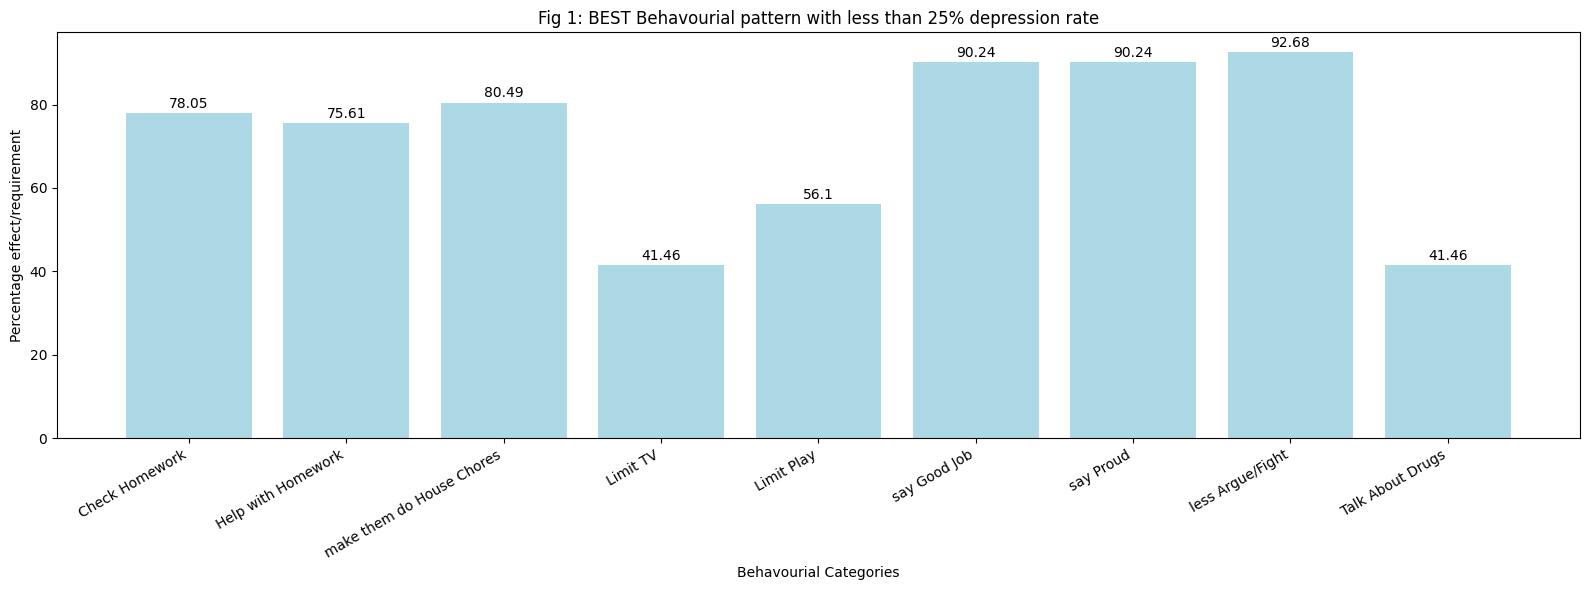

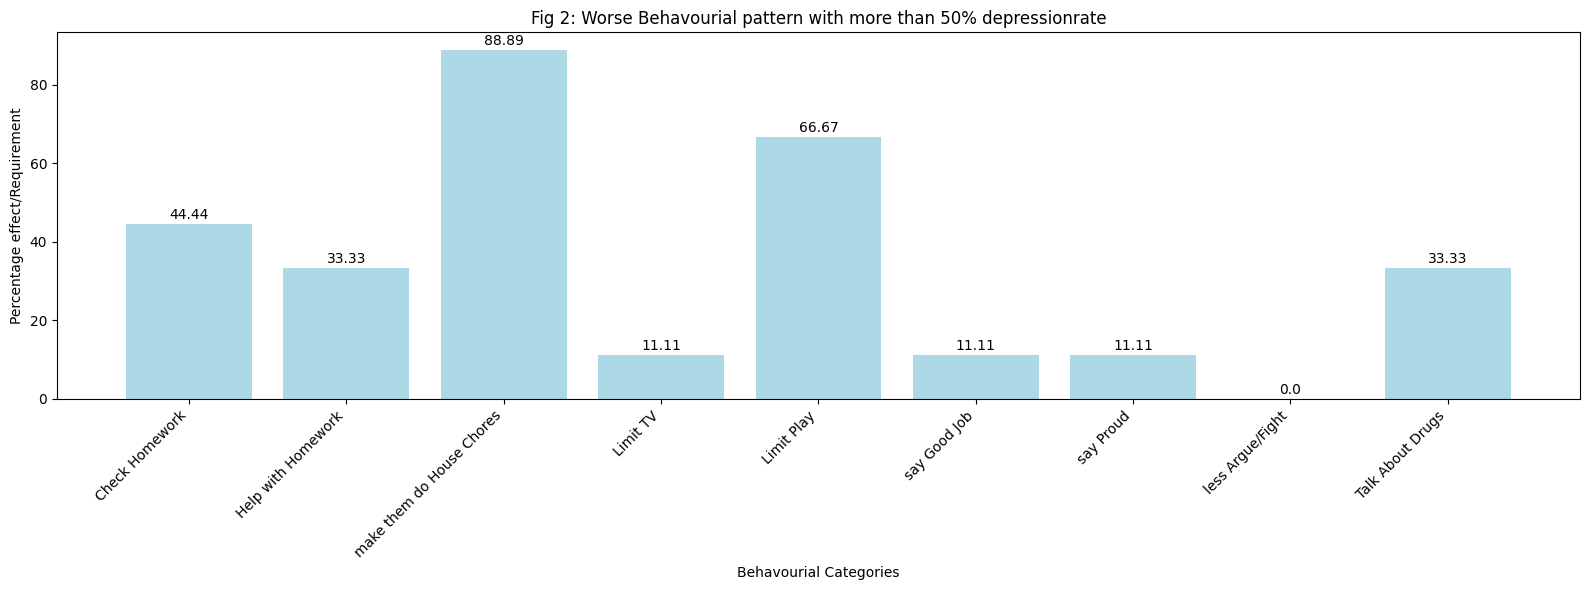

In [38]:
custom_labels = ['Check Homework', 'Help with Homework', 'make them do House Chores', 'Limit TV', 'Limit Play', 
                 'say Good Job', 'say Proud', 'less Argue/Fight', 'Talk About Drugs']

plt.figure(figsize=(16, 6))
bars = plt.bar(custom_labels, best_behavourial_mean_df['mean_value'], color='lightblue')

plt.xlabel('Behavourial Categories')
plt.ylabel('Percentage effect/requirement')
plt.title('Fig 1: BEST Behavourial pattern with less than 25% depression rate')

plt.xticks(rotation=30, ha='right')

for bar in bars:
    yval = bar.get_height() 
    plt.text(bar.get_x()+ bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', va='bottom')
plt.tight_layout()
plt.show()
plt.figure(figsize=(16, 6))
bars = plt.bar(custom_labels, worse_behavourial_mean_df['mean_value'], color='lightblue')
plt.xlabel('Behavourial Categories')
plt.ylabel('Percentage effect/Requirement') 
plt.title('Fig 2: Worse Behavourial pattern with more than 50% depressionrate')
plt.xticks(rotation=45, ha='right')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x()+ bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()

### CONCLUSION 

Fig 1 and fig 2 shows the behavioral pattern of parents and its effect of their kids. Fig 1 shows best patten and fig 2 shows the worse pattern

1. We can see that praising your kid whenever possible decreases depression by a lot and from 2nd graph we see parents who are not doing it have got more depressed kids in average
2. Limiting your kid TV and playtime moderately doesn't have severe effect on their mental health but if you strictly limit TV time and their play time, it might cause them to fall into depression. Hence when it comes to Playing and watching TV moderately strict restriction is fine for kids’ growth. 
3. Kids are happier when their parents get involved with their work like helping them with homework and checking their homework but parents who are not doing it have got more depressed kids in average.
4. For healthy mental health parents should avoid arguing with kids and find a way that kids doesn’t get the feeling to fight or argue as it effects mental health and it can be seen in Fig 2. Parents and kids who argue/fight with each other a lot will cause kid to fall into depression more in average. fighting/arguing less with kids have shown better mental health result.
5. From the fig1 and fig2, we can also see that on an average parent who talks to kids about effects of intoxicant on health have better mental health kids on average. But this factor is not a major factor as there is only slight increase

So, in Conclusion, Parents Behavioral patterns which cause the mental issues are primarily:

Important factor
1. Involvement with kids
2. Telling them they are proud of them and appreciate their effort
3. less Argument with kids

Moderate factor
1. Strictness with tv and playtime
2. let kids do the house chorus

less important factor:
1. talk about effects of intoxicant on them